In [1]:
import xarray as xr, matplotlib.pyplot as plt, numpy as np
import cftime
import xarray_tools as xrt
import iris, warnings
from pathlib import Path

In [2]:

# RUNDIRS=["/scratch/tm70/kr4383/cylc-run/cm3-run-29-01-2025-exp-runoff-smoothing-rmax-500-efold-1000"]
RUNDIRS=["/scratch/tm70/mrd599/cylc-run/cm3-suite"]
RUNS = []
do = {}
di = {}

for RUND in RUNDIRS:
    RUN = Path(RUND).name
    RUNS.append(RUN)
    # The ocean data mislabels the calendar as Gregorian, so read as raw times and convert to
    # proleptic_gregorian. Ice mislabels as noleap
    do[RUN] = xr.open_mfdataset(f'{RUND}/work/198*/atmos/access-cm3.mom6.h.native_*.nc', decode_times=False)
    do[RUN] = do[RUN].assign_coords(time=cftime.num2date(do[RUN].time.data, do[RUN].time.units, calendar="proleptic_gregorian"))
    # Ice data has end of month times, so reset to middle to match MOM
    # Rname dimensions to match ocean
    di[RUN] = xr.open_mfdataset(f'{RUND}/work/198*/atmos/access-cm3.cice.h.*nc', decode_times=False)
    di[RUN] = di[RUN].rename({'ni':'xh', 'nj':'yh'}).assign_coords({'xh':do[RUN]['xh'], 'yh':do[RUN]['yh']})
    di[RUN] = di[RUN].assign_coords(time=cftime.num2date(di[RUN].time_bounds.mean('nbnd').data, di[RUN].time.units, calendar="proleptic_gregorian"))


In [3]:
# Restricting it to just the required fields is much faster
# In some case river fields are on a different time axis and may need to be done separately ??
reqd = ['fld_s05i216', # precip
        'fld_s03i223', # evap
        'fld_s03i232', # evap from open sea
        'fld_s03i353', # sublimation over sea ice
        'fld_s08i023', # Snow mass
        'fld_s08i223', # Soil water
        'fld_s08i234', 'fld_s08i235',  # runoff
        'fld_s08i245', # Inland basin flow on atmospheric grid
        'fld_s08i250', # Deep layer ground water saturation fraction
        'fld_s30i403', # Total column dry mass
        'fld_s30i404', # Total column wet mass
        'fld_s26i001', # River storage (river grid)
        'fld_s26i002', # River grid box outflow (river grid)
        'fld_s26i003', # River grid box inflow (river grid)
        'fld_s26i004', # River outflow (atm grid)
        'fld_s26i006', # Inland basin flow (river grid)
        'time_bnds', 'lon_bnds', 'lat_bnds'
]

def _preprocess(d):
    return xr.Dataset({v:d[v] for v in reqd})

da = {}
for RUND in RUNDIRS:
    RUN = Path(RUND).name
    da[RUN] = xr.open_mfdataset(f'{RUND}/share/data/History_Data/netCDF/atmosa.pm198*nc', use_cftime=True, preprocess=_preprocess)


In [4]:
areacella = xr.open_dataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/fx/areacella/gn/latest/areacella_fx_ACCESS-CM2_piControl_r1i1p1f1_gn.nc').areacella
sftlf = iris.load_cube('/g/data/tm70/mrd599/ancil/n96e_momO1_20201102/qrparm.landfrac')
sftlf = xr.DataArray.from_iris(sftlf).rename({'latitude':'lat', 'longitude':'lon'})
oareacella = (1-sftlf)*areacella
omask = xr.where(sftlf==0, 0, np.nan)
lmask = xr.where(sftlf==1, 0, np.nan)
vegfrac = iris.load_cube('/g/data/tm70/mrd599/ancil/n96e_momO1_20201102/qrparm.veg.frac')
vegfrac = xr.DataArray.from_iris(vegfrac).rename({'latitude':'lat', 'longitude':'lon'})

# Volume fraction at saturation
vsat = iris.load_cube('/g/data/tm70/mrd599/ancil/n96e_momO1_20201102/qrparm.soil', 'soil_porosity')
vsat = xr.DataArray.from_iris(vsat).rename({'latitude':'lat', 'longitude':'lon'})

dstatic = xr.open_mfdataset(f'{RUND}/work/19810101/atmos/access-cm3.mom6.h.static.nc')
wet = dstatic.wet
mask = xr.where(wet==1.0, 0., np.nan)
areacello = xr.where(wet==1.0, dstatic.areacello, 0.)
ocean_vol = (dstatic['deptho']*areacello).sum().values
ocean_area = areacello.sum().values

# CICE ice and snow densities
rhoi = 917.
rhos = 330.
ocean_density = 1026.

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/coding/times.py:987: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/indexing.py:525: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


In [5]:
def global_mean(ds,weights):
    """ Area weighted global mean of a DataArray"""
    # Check the shapes match
    assert ds.shape[-2:] == weights.shape, 'Shape mismatch in global_mean'
    assert ds.dims[-2:] == weights.dims, 'Coordinate mismatch in global_mean'
    dims = weights.dims
    if (weights[dims[0]]==ds[dims[0]]).all() and (weights[dims[1]]==ds[dims[1]]).all():
        ds_w = ds.weighted(weights)
    elif np.allclose(weights[dims[0]].data,ds[dims[0]].data) and np.allclose(weights[dims[1]].data,ds[dims[1]].data):
        ds_w = ds.weighted(weights.reindex_like(ds, method='nearest', tolerance=1e-4))
        warnings.warn("Non exact grid match")
    else:
        raise ValueError("Grid mismatch")
    return ds_w.mean(dims)

def global_sum(ds,weights):
    """ Area weighted global mean of a DataArray"""
    # Check the shapes match
    assert ds.shape[-2:] == weights.shape, 'Shape mismatch in global_sum'
    assert ds.dims[-2:] == weights.dims, 'Coordinate mismatch in global_sum'
    dims = weights.dims
    if (weights[dims[0]]==ds[dims[0]]).all() and (weights[dims[1]]==ds[dims[1]]).all():
        ds_w = ds.weighted(weights)
    elif np.allclose(weights[dims[0]].data,ds[dims[0]].data) and np.allclose(weights[dims[1]].data,ds[dims[1]].data):
        ds_w = ds.weighted(weights.reindex_like(ds, method='nearest', tolerance=1e-4))
        warnings.warn("Non exact grid match")
    else:
        raise ValueError("Grid mismatch")
    return ds_w.sum(dims)

In [6]:
ssh = {RUN: xrt.global_mean(do[RUN]['SSH'], areacello).compute() for RUN in RUNS}
mass = {RUN: xrt.global_sum(do[RUN]['mass_wt'], areacello).compute() for RUN in RUNS}
snow = {RUN: xrt.global_sum(da[RUN]['fld_s08i023']*sftlf, areacella).compute() for RUN in RUNS}
atmwater = {RUN: xrt.global_sum(da[RUN]['fld_s30i404'] - da[RUN]['fld_s30i403'], areacella).compute() for RUN in RUNS}
soilwater = {RUN: xrt.global_sum(da[RUN]['fld_s08i223'].sum('depth')*sftlf, areacella).compute() for RUN in RUNS}
# Ground water is volume fraction in a 3 m layer
groundwater = {RUN: 3000.*xrt.global_sum(da[RUN]['fld_s08i250']*vsat*sftlf, areacella).compute() for RUN in RUNS}
icevol = {RUN: xrt.global_sum(di[RUN]['hi'], areacello).compute() for RUN in RUNS}
icesnowvol = {RUN: xrt.global_sum(di[RUN]['hs'], areacello).compute() for RUN in RUNS}
river_storage =  {RUN: da[RUN]['fld_s26i001'].sum(('lat_river', 'lon_river')).compute() for RUN in RUNS}

totmass = {RUN: mass[RUN] + rhoi*icevol[RUN] + rhos*icesnowvol[RUN] + snow[RUN] + soilwater[RUN] + groundwater[RUN] + river_storage[RUN] + atmwater[RUN] for RUN in RUNS}


Text(0.5, 1.0, 'Ground water')

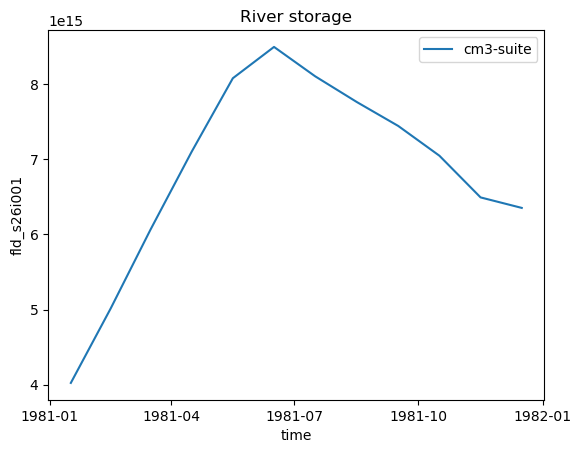

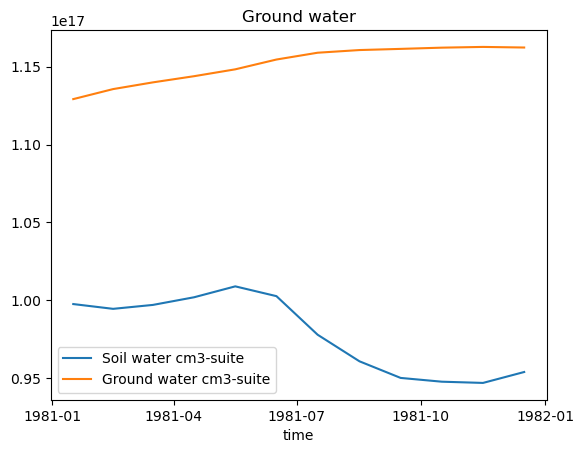

In [7]:
fig, axes = plt.subplots()
for RUN in RUNS:
    # river_storage[RUN].plot(label=RUN[19:])
    river_storage[RUN].plot(label=RUN)
axes.legend()
axes.set_title('River storage')
fig, axes = plt.subplots()
for RUN in RUNS:
    soilwater[RUN].plot(label=f'Soil water {RUN}')
    groundwater[RUN].plot(label=f'Ground water {RUN}')
axes.legend()
axes.set_title('Ground water')

Text(0.5, 1.0, 'Sea ice and snow on ice')

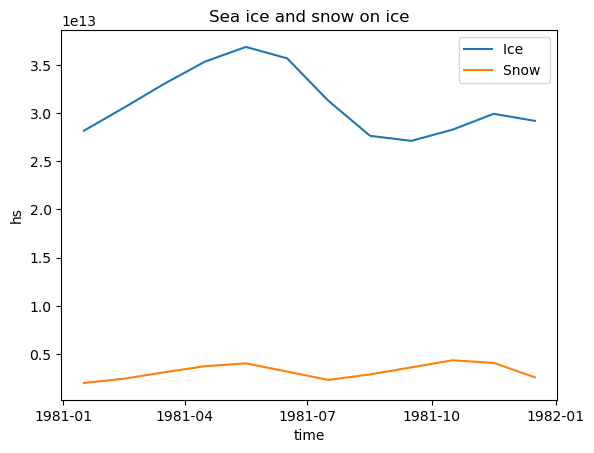

In [8]:
fig, axes = plt.subplots()
for RUN in RUNS:
    icevol[RUN].plot(label=f'Ice {RUN[19:]}')
    icesnowvol[RUN].plot(label=f'Snow {RUN[19:]}')
axes.legend()
axes.set_title('Sea ice and snow on ice')

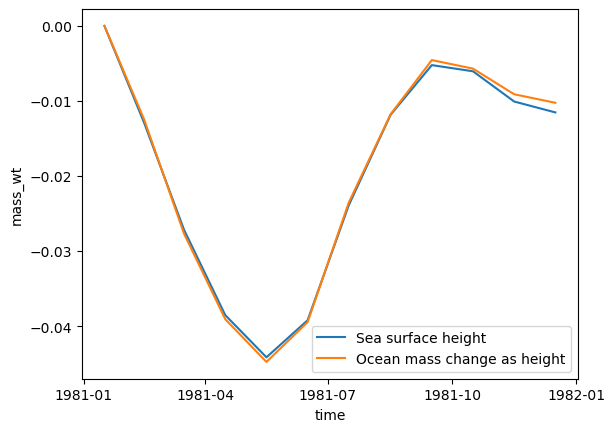

In [9]:
# Change in SSH and mass agree
run = RUNS[0]
fig, axes = plt.subplots()
(ssh[run] - ssh[run][0]).plot(label='Sea surface height')
((mass[run] - mass[run][0])/(ocean_density*ocean_area)).plot(label='Ocean mass change as height')
axes.legend()

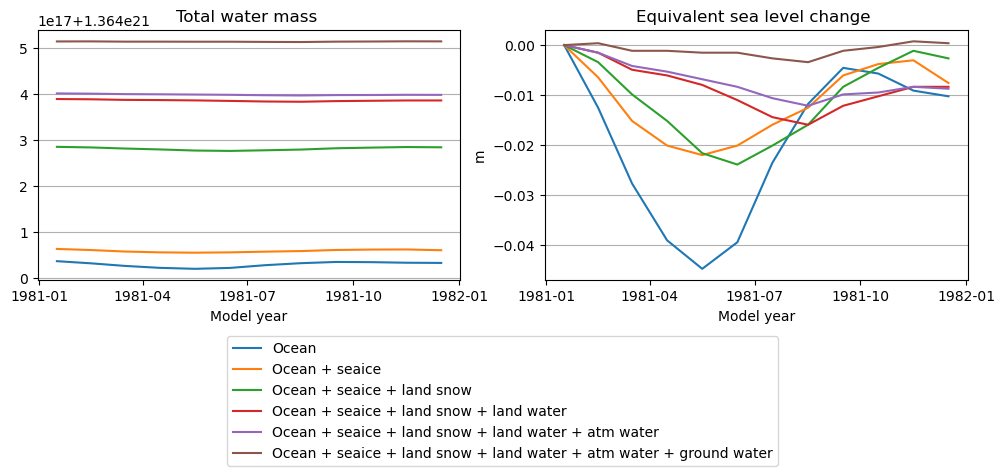

In [15]:
for RUN in RUNS:
    fig = plt.figure(figsize=(12,5), layout='constrained')
    axes = fig.add_subplot(1,2,1)
    m1 = mass[RUN]
    m2 = m1 + rhoi*icevol[RUN] + rhos*icesnowvol[RUN]
    m3 = m2 + snow[RUN]
    m4 = m3 + soilwater[RUN] + river_storage[RUN]
    m5 = m4 + atmwater[RUN]
    m6 = m5 + groundwater[RUN]
    m1.plot(label='Ocean')
    m2.plot(label='Ocean + seaice')
    m3.plot(label='Ocean + seaice + land snow ')
    m4.plot(label='Ocean + seaice + land snow + land water')
    m5.plot(label='Ocean + seaice + land snow + land water + atm water')
    m6.plot(label='Ocean + seaice + land snow + land water + atm water + ground water')
    # axes.legend()
    axes.grid(axis='y')
    axes.set_xlabel('Model year')
    axes.set_title(f'Total water mass {RUN[19:]}')
    # Shrink current axis's height by 20% on the bottom
    box = axes.get_position()
    axes.set_position([box.x0, box.y0 + box.height * 0.35,
                    box.width, box.height * 0.65])

    axes = fig.add_subplot(1,2,2)
    ((m1 - m1[0])/(ocean_density*ocean_area)).plot()
    ((m2 - m2[0])/(ocean_density*ocean_area)).plot()
    ((m3 - m3[0])/(ocean_density*ocean_area)).plot()
    ((m4 - m4[0])/(ocean_density*ocean_area)).plot()
    ((m5 - m5[0])/(ocean_density*ocean_area)).plot()
    ((m6 - m6[0])/(ocean_density*ocean_area)).plot()
    # axes.legend(loc='outside lower center')
    axes.set_xlabel('Model year')
    axes.set_title(f'Equivalent sea level change {RUN[19:]}')
    axes.set_ylabel('m')
    axes.grid(axis='y')

    # Shrink current axis's height by 20% on the bottom
    box = axes.get_position()
    axes.set_position([box.x0, box.y0 + box.height * 0.35,
                    box.width, box.height * 0.65])
    fig.legend(loc='outside lower center')
    # savefig(f'sealevel_{RUN}.png')

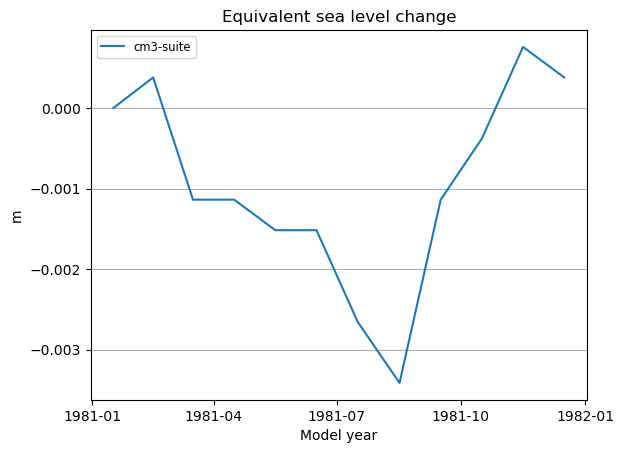

In [11]:
fig, axes = plt.subplots()
for RUN in RUNS:
    # ((totmass[RUN][:60] - totmass[RUN][0])/(ocean_density*ocean_area)).plot(label=RUN[19:])
    ((totmass[RUN] - totmass[RUN][0])/(ocean_density*ocean_area)).plot(label=RUN)
axes.set_xlabel('Model year')
axes.set_title('Equivalent sea level change')
axes.set_ylabel('m')
axes.grid(axis='y')
axes.legend(fontsize='small')
# savefig('sealevel.png')